Parameters that have to be changed for different forecast days

In [1]:
val = False #True - predict for validation period; False - predict for evaluation period
dend = 1914 if val else 1942 #first day of prediction period

wdayF = 3 #Forecasts for Mondays
hs = [8]
lags = ['lag0','lag1','lag2','lag3','lag6'] # 'lag1' actually translates to lag(1+h), 'lag0' to lag(h)

wdaysT = [3,7] #weekdays used for training; 1 Saturday - 7 Friday
wDayShifts = [[2,3,4,5,6],[0,1,2,3,6]]
wEndShifts = [[0,1],[4,5]]

dstart = 1100

Features that I use

In [2]:
features = ['Level',
    
            'mday','wOfMonth','quarter','is_weekend','year','month','wday','snap_CA', #calendar features
            'snap_WI','snap_TX','2events','event_type_1','event_name_1',
           
           'sell_price','sell_price_rel_diff','sell_price_abs_diff','sell_price_cumrel','sell_price_max', #sell_price features
           'sell_price_min','sell_price_mean','sell_price_norm','sell_price_roll_sd4','sell_price_rollNorm', 
            
           'item_id','dept_id','cat_id','store_id','state_id','roll_mean_t7','roll_mean_t14','roll_mean_t28', #sales features
           'roll_mean_t56','roll_mean_t84','roll_mean_t168','rolling_sd_t7','rolling_sd_t14',
           'rolling_sd_t28','last8wdays','last4wdays','last2wdays','lastWorkDaysMean','lastWeekendMean',
           'lastWeekTrend','lastMonthTrend','last2MonthTrend','roll_quant10','roll_quant25','roll_quant50',
           'roll_quant75','roll_quant90']  


targetEncode = ['event_name_1','event_type_1','month','wday','mday', #intra id target encoding; added with _tar appendix to features
                'wOfMonth','quarter','2events','snap_CA','snap_WI','snap_TX']  
targetEncode2 = ['item_id','dept_id','store_id','id_enc'] #target encoding (not intra id); added with _tar appendix to features

features = features + lags

LGBM Parameters to use

In [3]:
params = {'seed':20,
          'objective':'quantile', 
          'alpha':0.005,
          'num_leaves':63,
          'max_depth':15,                    
          'lambda':0.1, 
          'bagging_fraction':0.66,
          'bagging_freq':1,
          'colsample_bytree':0.77,
          "force_row_wise" : True,
          'learning_rate':0.1
        }

## Preliminary stuff ##

Code to install newest LGBM version

In [4]:
%%bash

git clone --recursive https://github.com/microsoft/LightGBM ; cd LightGBM
mkdir build ; cd build
export CMAKE_CXX_FLAGS='-O3 -mtune=native'
cmake ..
make -j$(nproc)
cd ../python-package/
python setup.py install --precompile

Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Performing Test MM_PREFETCH
-- Performing Test MM_PREFETCH - Success
-- Using _mm_prefetch
-- Performing Test MM_MALLOC
-- Performing Test MM_MALLOC - Success
-- Using _mm_

Cloning into 'LightGBM'...
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/kaggle/working/LightGBM/compute'...
cmake: /opt/conda/lib/libcurl.so.4: no version information available (required by cmake)
/usr/bin/cmake: /opt/conda/lib/libcurl.so.4: no version information available (required by /usr/bin/cmake)
/usr/bin/cmake: /opt/conda/lib/libcurl.so.4: no version information available (required by /usr/bin/cmake)
/usr/bin/cmake: /opt/conda/lib/libcurl.so.4: no version information available (required by /usr/bin/cmake)
/usr/bin/cmake: /opt/conda/lib/libcurl.so.4: no version information available (required by /usr/bin/cmake)
/usr/bin/cmake: /opt/conda/lib/libcurl.so.4: no version information available (required by /usr/bin/cmake)
/usr/bin/cmake: /opt/conda/lib/libcurl.so.4: no version information available (required by /usr/bin/cmake)
/usr/bin/cmake: /opt/conda/lib/libcurl.so.4: no version information available (required b

Importing libraries

In [5]:
import numpy as np # linear algebra
import numpy.ma as ma
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time, gc, sys
import lightgbm as lgb

pd.set_option('display.max_columns', 500)

Solving memory leak problem in pandas <br>
https://github.com/pandas-dev/pandas/issues/2659#issuecomment-12021083 <br>
(After pandas operations in the following code, call: libc.malloc_trim(0) and gc.collect())

In [6]:
from ctypes import cdll, CDLL
try:
    cdll.LoadLibrary("libc.so.6")
    libc = CDLL("libc.so.6")
    libc.malloc_trim(0)
except (OSError, AttributeError):
    libc = None

__old_del = getattr(pd.DataFrame, '__del__', None)

def __new_del(self):
    if __old_del:
        __old_del(self)
    libc.malloc_trim(0)

if libc:
    print('Applying monkeypatch for pd.DataFrame.__del__', file=sys.stderr)
    pd.DataFrame.__del__ = __new_del
else:
    print('Skipping monkeypatch for pd.DataFrame.__del__: libc or malloc_trim() not found', file=sys.stderr)

Applying monkeypatch for pd.DataFrame.__del__


Loading csv files

In [7]:
# Load data; weights contains weights and scaling coefficients for WRMSSE (calculated in getScalingCoeffs notebooks)
selling_prices = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv")
calendar = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/calendar.csv")
weights = pd.read_csv("/kaggle/input/getscalingcoeffs-uncertainty-evaluation/weightsAndScaling.csv") 
if val:
    salesRaw = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/sales_train_validation.csv")
else:
    salesRaw = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/sales_train_evaluation.csv") 

## Data preprocessing ##

Weights

In [8]:
weights['id'] = weights['Agg_Level_1']+'_'+weights['Agg_Level_2']
weights = weights[['id','Weight']]
weights.columns = ['id','weight']
weights['weight'] = (weights['weight']/weights['weight'].mean()).clip(lower=0.2,upper=30.).astype(np.float32)
weights.head(3)

,id,weight
0,Total_X,30.0
1,CA_X,30.0
2,TX_X,30.0


Calendar

In [9]:
calendar['d'] = calendar['d'].str[2:].astype(np.int16) #'d' column has form 'd_1', 'd_2' etc., delete 'd_'
calendar['mday'] = calendar['date'].str[-2:].astype(np.int8)
calendar['wOfMonth'] = calendar['mday']//7
calendar['event_name_1'] = (calendar['event_name_1'].factorize()[0] + 1).astype(np.int8) 
calendar['event_type_1'] = (calendar['event_type_1'].factorize()[0] + 1).astype(np.int8) 
calendar['2events'] = (~calendar['event_type_2'].isna()).astype(np.int8)
calendar['quarter'] = ((calendar['month']-1)//3).astype(np.int8)
calendar['is_weekend'] = calendar['wday'].isin([1,2]).astype(np.int8)
calendar['year'] = (calendar['year']-calendar['year'].min()).astype(np.int8)
calendar = calendar.astype({'wm_yr_wk':np.int32,'wday':np.int8,'month':np.int8,
                            'snap_CA':np.int8,'snap_TX':np.int8,'snap_WI':np.int8})
calendar.drop(columns=['date','weekday','event_name_2','event_type_2'],inplace=True) #drop date column (there are still columns wday, month, year left -> no info lost)
calendar = calendar[calendar['d']>=dstart]
calendar.head(3)

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,mday,wOfMonth,2events,quarter,is_weekend
1099,11401,1,2,3,1100,0,0,1,1,0,1,0,0,0,1
1100,11401,2,2,3,1101,1,1,1,0,1,2,0,0,0,1
1101,11401,3,2,3,1102,0,0,1,1,1,3,0,0,0,0


Selling prices 

In [10]:
### Building the 42840 rows from the 30490 ones (using mean selling price)
selling_prices = selling_prices[selling_prices['wm_yr_wk']>=calendar['wm_yr_wk'].min()]

selling_prices['total'] = 'Total'
selling_prices['cat_id'] = selling_prices['item_id'].map(lambda x: x.split('_')[0])
selling_prices['dept_id'] = selling_prices['item_id'].map(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
selling_prices['state_id'] = selling_prices['store_id'].map(lambda x: x.split('_')[0])

level_dfs = []
group_ids = ( 'total', 'state_id', 'store_id', 'cat_id', 'dept_id', 
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], 'item_id', ['state_id','item_id'], ['item_id', 'store_id']) 
for ii,grou in enumerate(group_ids): 
    if type(grou)==list:
        tmp = selling_prices.groupby(['wm_yr_wk']+grou).mean().reset_index()
        tmp['id'] = tmp[grou[0]] + '_' + tmp[grou[1]]
    else:
        tmp = selling_prices.groupby(['wm_yr_wk',grou]).mean().reset_index()
        tmp['id'] = tmp[grou] + '_X'
    for f in [x for x in ['state_id','store_id','cat_id','dept_id','item_id'] if x not in grou]:
        if type(grou)==list and (selling_prices.groupby(['wm_yr_wk']+grou)[f].nunique()==1).all():
            tmp = tmp.merge(selling_prices.groupby(['wm_yr_wk']+grou)[f].first().reset_index(),on=['wm_yr_wk']+grou)
        elif type(grou)==str and (selling_prices.groupby(['wm_yr_wk',grou])[f].nunique()==1).all():
            tmp = tmp.merge(selling_prices.groupby(['wm_yr_wk',grou])[f].first().reset_index(),on=['wm_yr_wk',grou])
        else:
            tmp[f] = np.nan
    if grou=='total':
        tmp.drop(columns=['total'],inplace=True)
    level_dfs += [tmp.copy()]
selling_prices = pd.concat(level_dfs,sort=False).reset_index().drop(columns='index')
selling_prices.drop(columns=['state_id','store_id','cat_id','dept_id','item_id'],inplace=True)
del level_dfs, tmp
#Pandas memory leak issue
libc.malloc_trim(0)
gc.collect()
selling_prices.head(3)

,wm_yr_wk,sell_price,id
0,11401,4.386978,Total_X
1,11402,4.387843,Total_X
2,11403,4.394502,Total_X


In [11]:
### insert nan prices for missing periods
wm_yr_wk_uniques = selling_prices['wm_yr_wk'].unique()
outOfStore_id = []
outOfStore_wm_yr_wk = []
for idd,avail_wk in selling_prices.groupby('id').wm_yr_wk.unique().iteritems():
    outOfStore_id += (len(wm_yr_wk_uniques) - len(avail_wk)) * [idd]
    outOfStore_wm_yr_wk += list(wm_yr_wk_uniques[~np.isin(wm_yr_wk_uniques,avail_wk)])
selling_prices = selling_prices.append(pd.DataFrame({'id':outOfStore_id,'wm_yr_wk':outOfStore_wm_yr_wk,'sell_price':np.nan}),ignore_index=True,sort=True)
del wm_yr_wk_uniques, outOfStore_id, outOfStore_wm_yr_wk

selling_prices = selling_prices.sort_values(by=['id', 'wm_yr_wk']) #sort values s.t. the groupby followed by shifts etc. works correctly in the following lines
selling_prices['sell_price_rel_diff'] =  (selling_prices['sell_price']/selling_prices.groupby('id')['sell_price'].shift(1)).astype(np.float16) #price change compared to last week
selling_prices['sell_price_abs_diff'] = (selling_prices['sell_price'] - selling_prices.groupby('id')['sell_price'].shift(1)).astype(np.float16) #price change compared to last week
selling_prices['sell_price_cumrel'] = ((selling_prices['sell_price'] - selling_prices.groupby('id')['sell_price'].cummin()) / (1e-4 + selling_prices.groupby('id')['sell_price'].cummax() - selling_prices.groupby('id')['sell_price'].cummin())).astype(np.float16) # (current prize - lowest price up to now) normalized by prize span until now; 
selling_prices['sell_price_max'] = selling_prices['id'].map(selling_prices.groupby('id')['sell_price'].max()).astype(np.float16)
selling_prices['sell_price_mean'] = selling_prices['id'].map(selling_prices.groupby('id')['sell_price'].mean()).astype(np.float16)
selling_prices['sell_price_min'] = selling_prices['id'].map(selling_prices.groupby('id')['sell_price'].min()).astype(np.float16)
selling_prices['sell_price_norm'] = (selling_prices['sell_price']/selling_prices['sell_price_max']).astype(np.float16)
selling_prices['sell_price_rollNorm'] = (selling_prices['sell_price']/selling_prices.groupby('id')['sell_price'].rolling(window=4,min_periods=2).mean().reset_index((0,1),drop=True)).astype(np.float16)
selling_prices['sell_price_roll_sd4'] = selling_prices.groupby('id')['sell_price'].rolling(window=4,min_periods=3).std().reset_index((0,1),drop=True).astype(np.float16) #standard deviation of the selling prices in the last 7 weeks
selling_prices = selling_prices.astype({'sell_price':np.float16,'wm_yr_wk':np.int32}) #reduce memory consumption
selling_prices.head(3)

,id,sell_price,wm_yr_wk,sell_price_rel_diff,sell_price_abs_diff,sell_price_cumrel,sell_price_max,sell_price_mean,sell_price_min,sell_price_norm,sell_price_rollNorm,sell_price_roll_sd4
6750,CA_1_FOODS,3.230469,11401,NaN,NaN,0.000000,3.353516,3.314453,3.230469,0.963379,NaN,NaN
6780,CA_1_FOODS,3.234375,11402,1.000977,0.004402,0.978027,3.353516,3.314453,3.230469,0.964355,0.599121,0.0
6810,CA_1_FOODS,3.236328,11403,1.000000,0.001144,0.982422,3.353516,3.314453,3.230469,0.964844,0.590332,0.0


Sales

In [12]:
### Building the 42840 rows from the 30490 ones in sales
salesRaw['id'] = salesRaw['id'].str[:-11] #delete the 'evaluation'/'validation' suffix in the 'id' column

salesRaw['total'] = 'Total' 
level_dfs = []
group_ids = ( 'total', 'state_id', 'store_id', 'cat_id', 'dept_id', 
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], 'item_id', ['state_id','item_id'], ['item_id', 'store_id']) 
for ii,grou in enumerate(group_ids): 
    if type(grou)==list:
        tmp = salesRaw.groupby(grou).sum().reset_index()
        tmp['id'] = tmp[grou[0]] + '_' + tmp[grou[1]]
    else:
        tmp = salesRaw.groupby(grou).sum().reset_index()
        tmp['id'] = tmp[grou] + '_X'
    for f in [x for x in ['state_id','store_id','cat_id','dept_id','item_id'] if x not in grou]:
        if (salesRaw.groupby(grou)[f].nunique()==1).all():
            tmp = tmp.merge(salesRaw.groupby(grou)[f].first().reset_index(),on=grou)
        else:
            tmp[f] = np.nan
    if grou=='total':
        tmp.drop(columns=['total'],inplace=True)
    tmp['Level']=ii+1
    level_dfs += [tmp.copy()]
salesRaw = pd.concat(level_dfs,sort=False).reset_index().drop(columns='index')
salesRaw['Level'] = salesRaw['Level'].astype(np.int8)
del level_dfs, tmp
#Pandas memory leak issue
libc.malloc_trim(0)
gc.collect()
salesRaw.head(3)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,...,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,id,state_id,store_id,cat_id,dept_id,item_id,Level
0,32631,31749,23783,25412,19146,29211,28010,37932,32736,25572,23071,23658,23756,26445,34833,36380,21804,24070,21443,20318,23721,31689,29283,23966,20501,20757,20277,22529,29908,28707,21240,22872,22046,23475,23572,31202,34876,24562,22752,22560,22626,25572,32225,31417,24935,24021,22765,21779,23855,30599,29643,23101,20492,19230,18854,23350,29620,29866,21449,19581,18928,21742,28309,33478,33058,24852,23581,22656,22901,24754,31745,31536,24829,23218,21611,21964,25482,29234,29787,22389,19474,20188,19768,24279,29575,24018,20004,18113,17929,18145,22735,28101,29045,22837,24080,20761,21184,24486,28412,23688,25024,22231,22165,22413,25648,28736,31320,22213,19613,18770,18684,21649,27112,26246,20954,19203,19058,20480,22481,25527,23449,22538,19555,23165,22681,26781,30310,31604,26685,25089,24453,24782,26419,29940,31094,25752,24155,25258,22706,24712,28825,2610

In [13]:
#Sales - have to be processed for every h -> write function
def getProcessedSales(h):
    sales = salesRaw.copy()
    sales = sales.astype(dict(zip(['d_'+str(x) for x in range(1,dend)],(dend-1)*[np.float32])))
    sales = sales.sort_values(by='id')
    
    print('Check 1')
    
    # remove by interpolation the extreme events Christmas and Thanksgiving and other clear outliers
    christmas = [331,697,1062,1427,1792] #d_x is Christmas
    thanksgiving = [300, 664, 1035, 1399, 1763] 
    outliers = [1413]
    rmDays = outliers + christmas + thanksgiving #completely remove those days later (interpolate here for better rolling means etc)
    for d in rmDays:
        sales['d_'+str(d)] = 0.5 * (sales['d_'+str(d-1)] + sales['d_'+str(d+1)])    
        
    #Normalize sales (intra-id processing; first adjust mean s.t. sales for all ids have similar means, then remove trends)
    salesMat = sales[['d_'+str(ii) for ii in range(1,dend)]].values.astype(np.float32)
    newInStore = np.argmax(salesMat!=0,axis=1)//7 * 7 #always new for weekstart; set sales before release to nan instead of zero.
    for ii in range(len(salesMat)):
        salesMat[ii,:newInStore[ii]] = np.nan
    #mean adjustment
    means = np.apply_along_axis(lambda row: np.nanmean(row[row!=0]), axis=1, arr=salesMat) #normalize with the mean of NONZERO elements
    salesMat = (salesMat.T/means).T
    factors = pd.DataFrame({'id':sales['id'],'factor':means}) #to get original data multiply prediction with factor
    #trend adjustment
    rollMean = np.apply_along_axis(lambda row: np.convolve(row, np.ones(28)/28,mode='valid'), axis=1, arr=salesMat)
    rollMean[np.isnan(rollMean)] = np.apply_along_axis(lambda row: np.convolve(row, np.ones(7)/(7),mode='valid'), axis=1, arr=salesMat)[:,28-7:][np.isnan(rollMean)]
    adjust = (np.nanmax(rollMean,axis=1) - rollMean.T).T
    adjust[np.isnan(adjust)] = 0
    salesMat[:,-(adjust.shape[1]-h):] += adjust[:,:-h] #shift the adjustment by h to be able to undo it for prediction period
    trendAdjust = pd.DataFrame({'id':sales['id'],'adjust':adjust[:,-1]})
    #write to sales dataframe
    sales.loc[:,['d_'+str(ii) for ii in range(1,dend)]] = salesMat    
    
    del salesMat, newInStore, means, adjust
    
    sales.drop(columns=['d_'+str(x) for x in range(1,dstart)],inplace=True) #drop columns before dstart
    for d in range(dend,dend+h): #create new columns for prediction days until horizon
        sales['d_'+str(d)] = 0
    
    #restructure the table: for each object (defined by its id), the columns d_1,...,d_1969 are replaced by 1969 rows with 
    #columns 'd' - day id and 'demand' - number sold articles on that day
    sales = sales.melt(id_vars=("id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "Level"),var_name='d',value_name='demand') 
    sales['d'] = sales['d'].str[2:].astype(np.int16) #'d' column has form 'd_1', 'd_2' etc., delete 'd_'
    
    #print('Check 3')
    
    #encode columns as integers
    sales['item_id'] = sales['item_id'].factorize()[0].astype(np.int16) + 1 
    sales['dept_id'] = sales['dept_id'].factorize()[0].astype(np.int8) + 1
    sales['cat_id'] = sales['cat_id'].factorize()[0].astype(np.int8) + 1
    sales['store_id'] = sales['store_id'].factorize()[0].astype(np.int8) + 1
    sales['state_id'] = sales['state_id'].factorize()[0].astype(np.int8) + 1
    sales['state_id'] = sales['state_id'].astype(np.int8) + 1
    sales['id_enc'] = sales['id'].factorize()[0].astype(np.int16) + 1 
    
    #merge with calendar s.t. we can build target encodings as well for calendar features
    sales = sales.merge(calendar,on='d')
    
    #print('Check 4')
    
    #targetEncode; intra id target encoding; will be added with _tar appendix to the features;
    for col in targetEncode:
        sales = sales.merge(sales[sales['d']<dend].groupby(['id',col])['demand'].mean().rename(col+'_tar').reset_index())
        sales[col+'_tar'] = sales[col+'_tar'].astype(np.float16)
        features.append(col+'_tar')
        #Pandas memory leak issue
        libc.malloc_trim(0)
        gc.collect()
    #targetEncode2; not intra id; will be added with _tar appendix to the features;
    for col in targetEncode2: 
        sales = sales.merge(sales[sales['d']<dend].groupby(col)['demand'].mean().rename(col+'_tar').reset_index(),on=col)
        sales[col+'_tar'] = sales[col+'_tar'].astype(np.float16)
        features.append(col+'_tar')
        #Pandas memory leak issue
        libc.malloc_trim(0)
        gc.collect()

    #print('Check 5')
    
    #compute further sales features
    sales = sales.sort_values(by=['id', 'd']) #sort values s.t. the groupby followed by shifts etc. works correctly in the following
    sales['demand'] = sales['demand'].astype(np.float32)
    sales['lag0'] = sales.groupby('id')['demand'].shift(h).astype(np.float16)
    #rolling means
    sales['roll_mean_t7'] = sales.groupby('id')['lag0'].rolling(window=7,min_periods=7).mean().reset_index(0,drop=True).astype(np.float16)
    sales['roll_mean_t14'] = sales.groupby('id')['lag0'].rolling(window=14,min_periods=7).mean().reset_index(0,drop=True).astype(np.float16)
    sales['roll_mean_t28'] = sales.groupby('id')['lag0'].rolling(window=28,min_periods=14).mean().reset_index(0,drop=True).astype(np.float16)
    sales['roll_mean_t56'] = sales.groupby('id')['lag0'].rolling(window=56,min_periods=14).mean().reset_index(0,drop=True).astype(np.float16)
    sales['roll_mean_t84'] = sales.groupby('id')['lag0'].rolling(window=84,min_periods=28).mean().reset_index(0,drop=True).astype(np.float16)
    sales['roll_mean_t168'] = sales.groupby('id')['lag0'].rolling(window=168,min_periods=28).mean().reset_index(0,drop=True).astype(np.float16)
    #rolling quantiles
    sales['roll_quant10'] = sales.groupby('id')['lag0'].rolling(window=35,min_periods=21).quantile(0.1).reset_index(0,drop=True).astype(np.float16)
    sales['roll_quant25'] = sales.groupby('id')['lag0'].rolling(window=21,min_periods=14).quantile(0.25).reset_index(0,drop=True).astype(np.float16)
    sales['roll_quant50'] = sales.groupby('id')['lag0'].rolling(window=14,min_periods=7).quantile(0.5).reset_index(0,drop=True).astype(np.float16)
    sales['roll_quant75'] = sales.groupby('id')['lag0'].rolling(window=21,min_periods=14).quantile(0.75).reset_index(0,drop=True).astype(np.float16)
    sales['roll_quant90'] = sales.groupby('id')['lag0'].rolling(window=35,min_periods=21).quantile(0.9).reset_index(0,drop=True).astype(np.float16)
    #rolling sd features
    sales['rolling_sd_t7'] = sales.groupby('id')['lag0'].rolling(window=7,min_periods=7).std().reset_index(0,drop=True).astype(np.float16) #standard deviation of demand 28-34 days earlier
    sales['rolling_sd_t14'] = sales.groupby('id')['lag0'].rolling(window=14,min_periods=7).std().reset_index(0,drop=True).astype(np.float16) #standard deviation of demand 28-34 days earlier
    sales['rolling_sd_t28'] = sales.groupby('id')['lag0'].rolling(window=28,min_periods=14).std().reset_index(0,drop=True).astype(np.float16)
    #last same wdays
    sales['last8wdays'] = sales.groupby('id')['demand'].shift(h+7-h%7)
    for ii in range(2,9):
        sales['last8wdays'] += sales.groupby('id')['demand'].shift(h+ii*7-h%7)
        if ii == 2:
            sales['last2wdays'] = (sales['last8wdays']/2).astype(np.float16)
        if ii == 4:
            sales['last4wdays'] = (sales['last8wdays']/4).astype(np.float16)
    sales['last8wdays'] = (sales['last8wdays']/8).astype(np.float16)
    sales['last4wdays'].fillna(sales['last2wdays'],inplace=True) #to reduce nb of nan entries
    sales['last8wdays'].fillna(sales['last4wdays'],inplace=True)
    #others
    sales['lastWorkDaysMean'] = np.zeros(len(sales),dtype=np.float16)
    sales['lastWeekendMean'] = np.zeros(len(sales),dtype=np.float16)
    for ii in range(len(wdaysT)):
        sales.loc[sales['wday']==wdaysT[ii],'lastWorkDaysMean'] = sales.groupby('id')['demand'].shift(h+wDayShifts[ii][0])[sales['wday']==wdaysT[ii]]
        for jj in range(1,len(wDayShifts[ii])):
            sales.loc[sales['wday']==wdaysT[ii],'lastWorkDaysMean'] += sales.groupby('id')['demand'].shift(h+wDayShifts[ii][jj])[sales['wday']==wdaysT[ii]]
        sales.loc[sales['wday']==wdaysT[ii],'lastWeekendMean'] = ((sales.groupby('id')['demand'].shift(h+wEndShifts[ii][0])+sales.groupby('id')['demand'].shift(h+wEndShifts[ii][1]))/2).astype(np.float16)[sales['wday']==wdaysT[ii]] #only given that one considers only the forecast wday
        sales['lastWorkDaysMean'] /= 5    
    sales['lastWeekTrend'] = sales['roll_mean_t7'].shift(7) - sales['roll_mean_t7']
    sales['lastMonthTrend'] =  sales['roll_mean_t28'].shift(28) - sales['roll_mean_t28']
    sales['last2MonthTrend'] =  sales['roll_mean_t56'].shift(56) - sales['roll_mean_t56']
    # additional lags: 'lag0' actually translates to lag(h), 'lag1' to lag(h+1) and so on
    tmp = pd.DataFrame({'id':sales['id'].values,'d':sales['d'].values,'demand':sales['demand'].values}) #somehow this is necessary; going directly for sales[['id','demand']].groupby('id').shift(...) or even sales.groupby('id').shift(...) produces memory errors
    tmp = tmp.sort_values(by=['id', 'd']) #same sorting as for sales; lag stuff below should work correctly
    for lag in lags:
        if lag != 'lag0':
            sales[lag] = tmp.groupby('id')['demand'].shift(h+int(lag[3:])).astype(np.float16).values
    
    del tmp
    #Pandas memory leak issue
    libc.malloc_trim(0)
    gc.collect()
    
    #print('Check 6')
    
    # consider only days in wdaysT for training (and forecasting...)
    sales = sales[sales['wday'].isin(wdaysT)] #drop all other days
    #remove rows that have nan values 
    sales = sales[(~sales.isna().any(axis=1)) | (sales['d'] >= dend-28)] 
    #remove rmDays
    sales = sales[~sales['d'].isin(rmDays)] 
    sales['demand'].fillna(0,inplace=True)
    
    #Discard everything of CA_2 before 2016 and of WI_1, WI_2 before 2013 (due to the great shifts at that dates shown in the EDA kernel of heads or tails:
    #https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda )
    sales = sales[~(sales['id'].str.contains('CA_2') & (sales['year']<5))]
    sales = sales[~(sales['id'].str.contains('|'.join(['WI_1','WI_2'])) & (sales['year']<2))]
    
    #print('Check 7')
    
    #merge with selling prices
    sales = selling_prices.merge(sales,on=['id', 'wm_yr_wk'])
    sales.drop(columns='wm_yr_wk',inplace=True) #not used as feature, was just needed for merge
    
    #print('Check 8')
    
    #merge with weights for LGBM
    sales = weights.merge(sales,on='id')
    
    #print('Check 9')
    
    return sales, factors, trendAdjust

## Start Modelling ##

Modelling for horizon h = 8
____________________
Check 1
Quartile 0.005
____________________
[LightGBM] [Info] Total Bins 13035
[LightGBM] [Info] Number of data points in the train set: 8256826, number of used features: 69
[LightGBM] [Info] Start training from score 0.120136
Training until validation scores don't improve for 100 rounds
[100]	train's quantile: 0.00434889	validES's quantile: 0.00472856
[200]	train's quantile: 0.00388661	validES's quantile: 0.00443083
[300]	train's quantile: 0.0037524	validES's quantile: 0.00437234
[400]	train's quantile: 0.00366015	validES's quantile: 0.00433715
[500]	train's quantile: 0.00363408	validES's quantile: 0.00432151
[600]	train's quantile: 0.00360561	validES's quantile: 0.00430977
Early stopping, best iteration is:
[596]	train's quantile: 0.00360596	validES's quantile: 0.0043086

Quartile 0.025
____________________
[LightGBM] [Info] Total Bins 13035
[LightGBM] [Info] Number of data points in the train set: 8256826, number of used features: 69


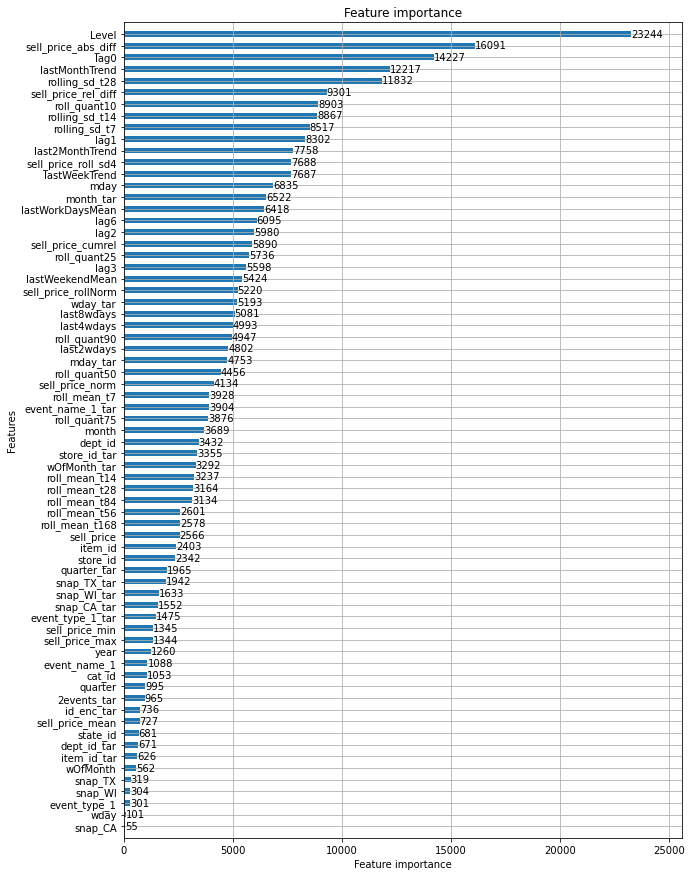

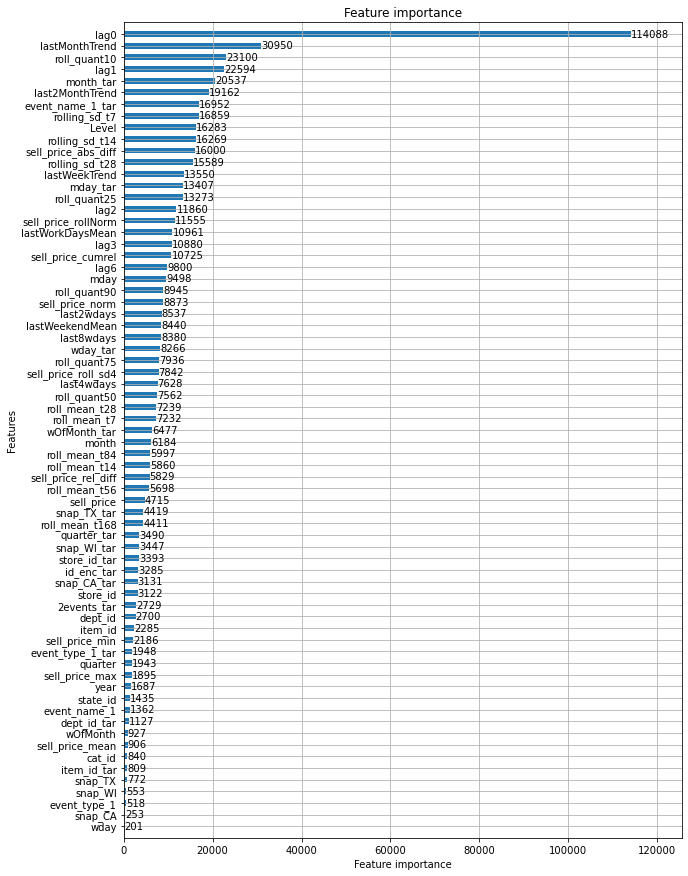

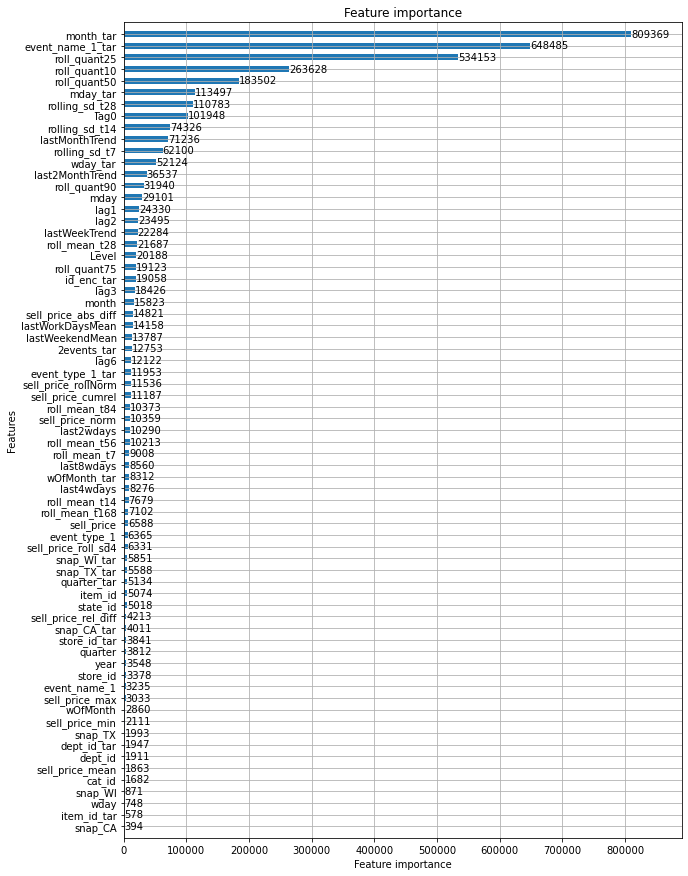

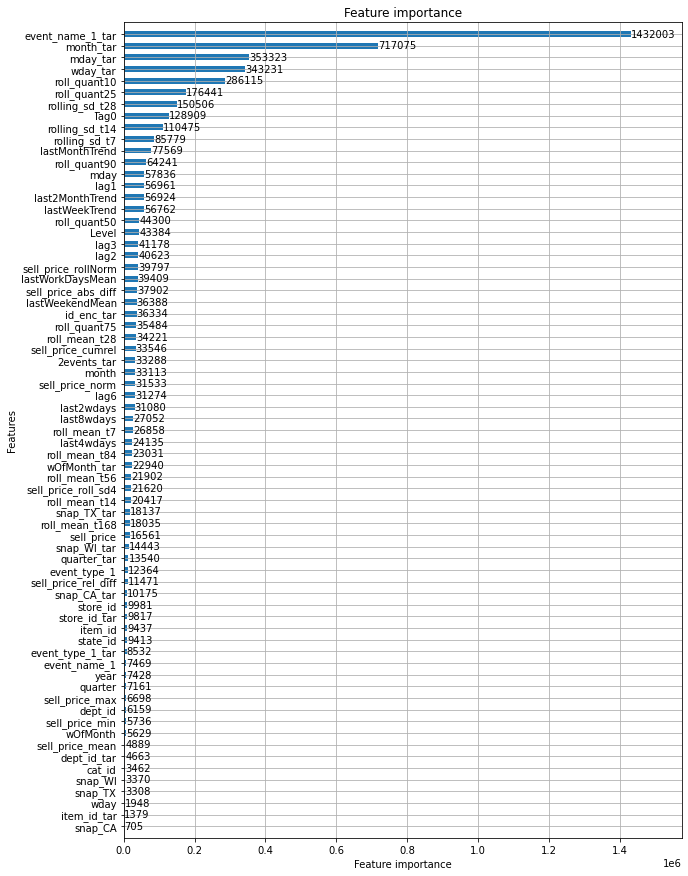

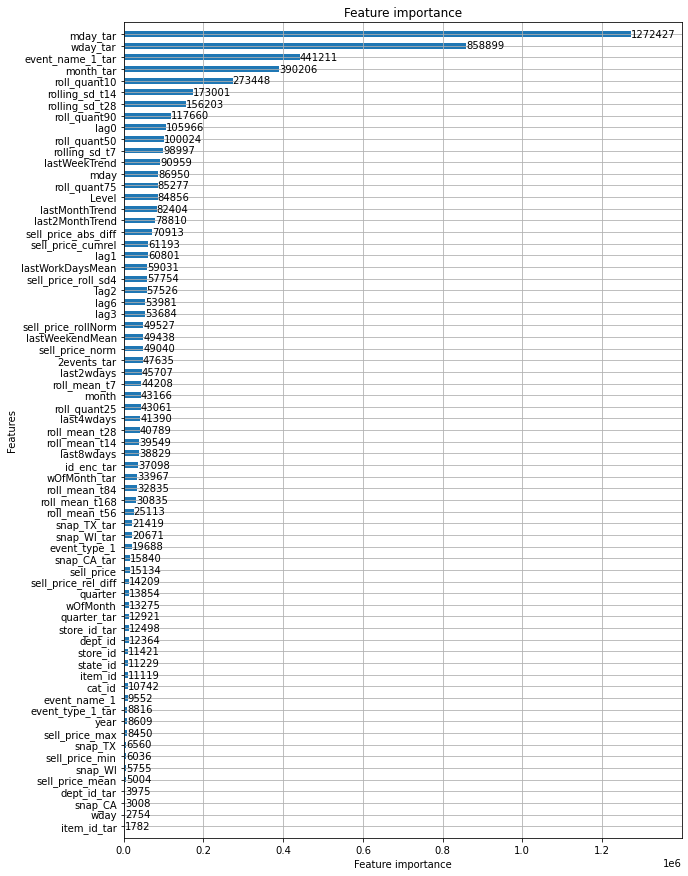

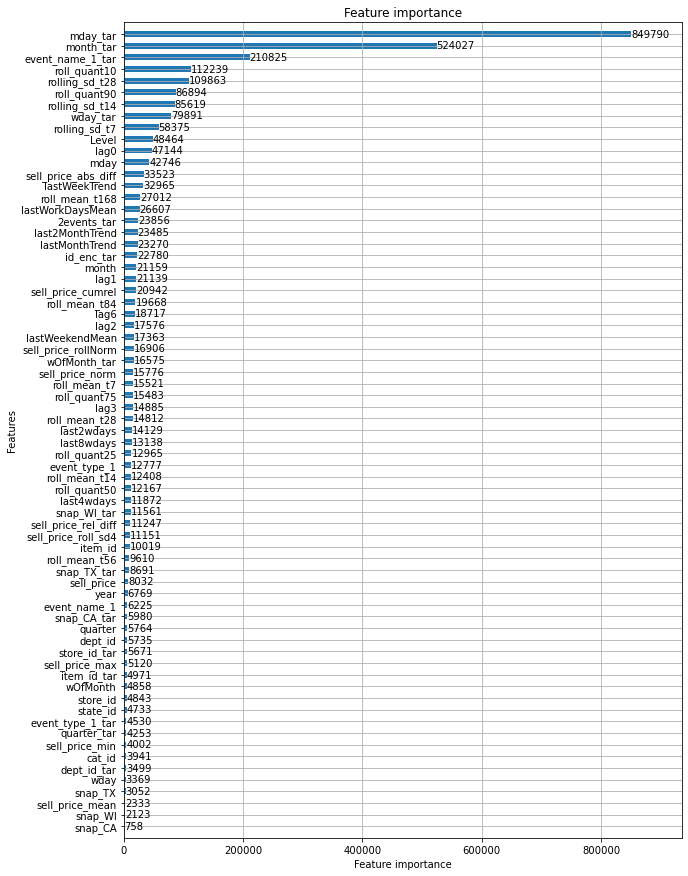

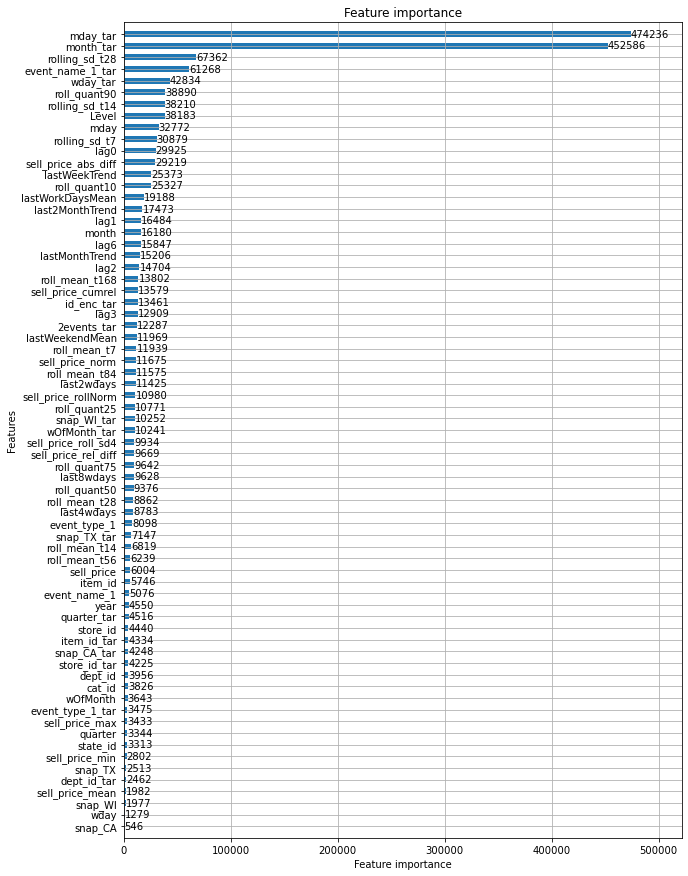

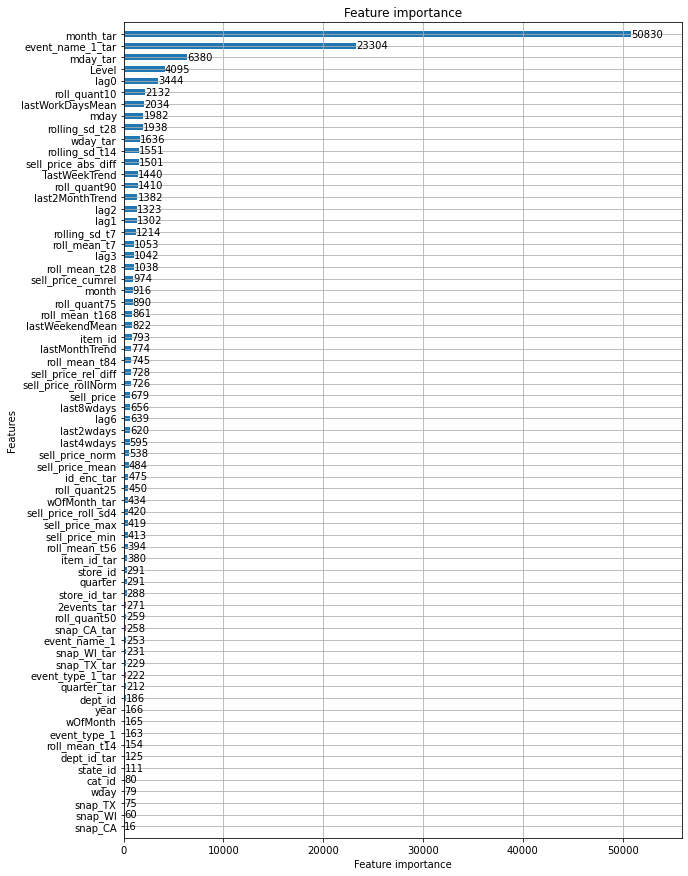

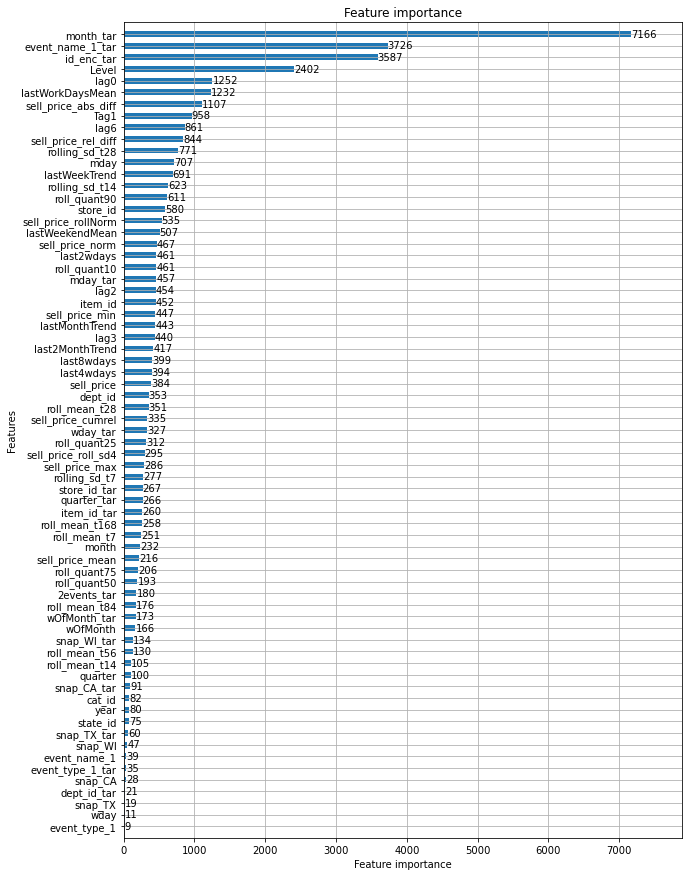

In [14]:
predictions = pd.DataFrame({'id':pd.concat(weights['id']+'_'+str(q) for q in [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995])})
for h in hs:
    print('Modelling for horizon h =',h)
    print(20*'_')
    sales, factors, trendAdjust = getProcessedSales(h)
    
    train = sales[sales['d'] < dend-28] #use last 28 days for early stopping
    train = lgb.Dataset(train[features],train[['demand']],weight=train['weight'])
    
    validES = sales[(sales['d'] >= dend - 28) & (sales['d'] < dend)] #validation set for  early stopping
    validES = lgb.Dataset(validES[features],validES[['demand']],reference=train,weight=validES['weight'])
    
    ids = []
    preds = []
    for q in [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]:
        print('Quartile', q)
        print(20*'_')
        params['alpha']=q
        pred = sales[sales['d']==dend+h-1].copy() 
    
        model = lgb.train(params,train_set=train,valid_sets=[train,validES],valid_names=['train','validES'],verbose_eval = 100,
                         early_stopping_rounds=100,num_boost_round=3000)

        lgb.plot_importance(model,importance_type="gain", precision=0, height=0.5, figsize=(10, 15))
        
        pred['demand'] = model.predict(pred[features])
        pred = pred[['id','demand']] #bring to correct format for WRMSSE function
        pred.columns = ['id','F'+str(h)]
        # undo preprocessing
        pred = pred.merge(factors,on='id')  #trendAdjust = pd.DataFrame({'id':sales.id.str[:-11],'adjust'
        pred = pred.merge(trendAdjust,on='id')
        #trend
        pred['F'+str(h)] = pred['F'+str(h)] - pred['adjust']
        #mean
        pred['F'+str(h)] = pred['F'+str(h)] * pred['factor']
        pred.drop(columns=['adjust','factor'],inplace=True) 
        #clip predicted values below zero
        pred['F'+str(h)] = pred['F'+str(h)].clip(lower=0)
        
        #save predictions for this quantile to merge later on to predictions dataframe
        ids += list((pred['id'] + '_' + str(q)).values)
        preds += list(pred['F'+str(h)].values)
        
        del model, pred
        #Pandas memory leak issue
        libc.malloc_trim(0)
        gc.collect()
        print()
    
    predictions = predictions.merge(pd.DataFrame({'id':ids,'F'+str(h):preds}),on='id')
    predictions['F'+str(h)] = predictions['F'+str(h)].astype(np.float32)
    del train, validES
    #Pandas memory leak issue
    libc.malloc_trim(0)
    gc.collect()
    print()
    print()

In [15]:
predictions.to_csv('preds.csv',index=False)

In [16]:
predictions.describe()

,F8
count,385560.000000
mean,12.558838
std,341.458282
min,0.000000
25%,0.000000
50%,0.878149
75%,3.250513
max,57199.417969
